In [1]:
import pandas as pd 

test = pd.read_csv("data/aluminum_coldRoll_testNoY.csv")
train = pd.read_csv("data/aluminum_coldRoll_train.csv")
alloy = pd.read_csv("data/ally.csv")

In [2]:
# Ensure alloy column is string (important!)
train["alloy"] = train["alloy"].astype(str)
test["alloy"] = test["alloy"].astype(str)
alloy["alloy"] = alloy["alloy"].astype(str)

# Merge the composition columns into train/test
train = train.merge(alloy, on="alloy", how="left")
test = test.merge(alloy, on="alloy", how="left")
test_ids = test["ID"]

In [4]:
train_df = train.copy()
test_df = test.copy()
y = train_df["y_passXtremeDurability"]


In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from catboost import CatBoostClassifier, Pool


In [6]:
cat_cols = [
    "alloy", "cutTemp", "rollTemp", "topEdgeMicroChipping",
    "blockSource", "machineRestart"
]

num_cols_base = [
    "firstPassRollPressure", "secondPassRollPressure",
    "contourDefNdx", "clearPassNdx"
]

chem_cols = ["Cu","Mg","Mn","Si","Zn","Cr","Fe","Ti","Ag","Zr"]


/Users/harshgovindji/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (11). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/harshgovindji/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (12). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/harshgovindji/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/Users/harshgovindji/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (10) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_met

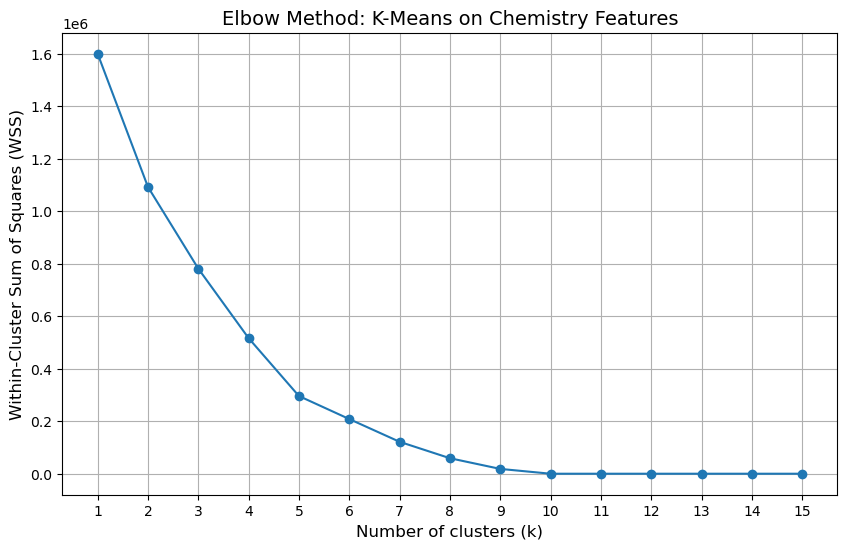

In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --------------------------------------------
# 1. Select chemistry columns
# --------------------------------------------
chem_cols = ["Cu","Mg","Mn","Si","Zn","Cr","Fe","Ti","Ag","Zr"]

X = train_df[chem_cols].copy()

# Optional: scale (K-means performs better on normalized data)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --------------------------------------------
# 2. Compute WSS for k = 1 to k = 15
# --------------------------------------------
wss = []
K_range = range(1, 16)

for k in K_range:
    model = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20,
        max_iter=300
    )
    model.fit(X_scaled)
    wss.append(model.inertia_)   # inertia_ = WSS

# --------------------------------------------
# 3. Plot WSS vs number of clusters
# --------------------------------------------
plt.figure(figsize=(10, 6))
plt.plot(K_range, wss, marker='o')
plt.xticks(K_range)
plt.xlabel("Number of clusters (k)", fontsize=12)
plt.ylabel("Within-Cluster Sum of Squares (WSS)", fontsize=12)
plt.title("Elbow Method: K-Means on Chemistry Features", fontsize=14)
plt.grid(True)
plt.show()


In [7]:
def add_cat_interactions(df):
    df = df.copy()
    df["alloy_cutTemp"] = df["alloy"] + "_" + df["cutTemp"]
    df["alloy_rollTemp"] = df["alloy"] + "_" + df["rollTemp"]
    df["alloy_block"] = df["alloy"] + "_" + df["blockSource"]
    df["alloy_micro"] = df["alloy"] + "_" + df["topEdgeMicroChipping"]
    df["restart_block"] = df["machineRestart"] + "_" + df["blockSource"]
    return df

train_df = add_cat_interactions(train_df)
test_df  = add_cat_interactions(test_df)

# update categorical list
cat_cols_extended = cat_cols + [
    "alloy_cutTemp","alloy_rollTemp","alloy_block",
    "alloy_micro","restart_block"
]


In [8]:
scaler = StandardScaler()
pca = PCA(n_components=3, random_state=42)

scaled_chem_train = scaler.fit_transform(train_df[chem_cols])
scaled_chem_test  = scaler.transform(test_df[chem_cols])

pca_train = pca.fit_transform(scaled_chem_train)
pca_test  = pca.transform(scaled_chem_test)

train_df["chem_PC1"] = pca_train[:,0]
train_df["chem_PC2"] = pca_train[:,1]
train_df["chem_PC3"] = pca_train[:,2]

test_df["chem_PC1"] = pca_test[:,0]
test_df["chem_PC2"] = pca_test[:,1]
test_df["chem_PC3"] = pca_test[:,2]


In [9]:
# KMeans
kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)
train_df["km_cluster"] = kmeans.fit_predict(scaled_chem_train)
test_df["km_cluster"] = kmeans.predict(scaled_chem_test)

# GMM
gmm = GaussianMixture(n_components=6, covariance_type="full", random_state=42)
train_df["gmm_cluster"] = gmm.fit_predict(scaled_chem_train)
test_df["gmm_cluster"] = gmm.predict(scaled_chem_test)


In [10]:
cat_cols_final = cat_cols_extended + ["km_cluster", "gmm_cluster"]


In [12]:
# Target
y = train_df["y_passXtremeDurability"]

# Features (all except ID + target)
feature_cols = [c for c in train_df.columns if c not in ["ID","y_passXtremeDurability"]]

# Correct cat index mapping (relative to feature_cols)
cat_feature_indices = [feature_cols.index(c) for c in cat_cols_final]

train_pool = Pool(
    data=train_df[feature_cols],
    label=y,
    cat_features=cat_feature_indices
)

test_pool = Pool(
    data=test_df[feature_cols],
    cat_features=cat_feature_indices
)


In [13]:
# -------------------------
# Fixed CatBoost parameters
# -------------------------
fixed_params = dict(
    loss_function="Logloss",
    eval_metric="Logloss",
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=4,
    random_strength=2,
    border_count=128,
    iterations=2000,
    od_type="Iter",
    od_wait=100,
    random_state=42,
    verbose=200
)

# -------------------------
# Train the model
# -------------------------
model = CatBoostClassifier(**fixed_params)

model.fit(
    train_pool,
    eval_set=train_pool,     # we use same to ensure fair test (we aren't tuning)
    use_best_model=True
)


0:	learn: 0.6737909	test: 0.6737839	best: 0.6737839 (0)	total: 151ms	remaining: 5m 1s
200:	learn: 0.4272080	test: 0.4268960	best: 0.4268960 (200)	total: 15.6s	remaining: 2m 19s
400:	learn: 0.4208963	test: 0.4212976	best: 0.4212976 (400)	total: 30.8s	remaining: 2m 2s
600:	learn: 0.4188969	test: 0.4199616	best: 0.4199616 (600)	total: 48.1s	remaining: 1m 52s
800:	learn: 0.4170810	test: 0.4189043	best: 0.4189043 (800)	total: 1m 4s	remaining: 1m 36s
1000:	learn: 0.4155270	test: 0.4182081	best: 0.4182081 (1000)	total: 1m 20s	remaining: 1m 20s
1200:	learn: 0.4139723	test: 0.4175465	best: 0.4175465 (1200)	total: 1m 37s	remaining: 1m 4s
1400:	learn: 0.4126789	test: 0.4170214	best: 0.4170214 (1400)	total: 1m 53s	remaining: 48.4s
1600:	learn: 0.4112635	test: 0.4163416	best: 0.4163416 (1600)	total: 2m 9s	remaining: 32.2s
1800:	learn: 0.4098747	test: 0.4157138	best: 0.4157138 (1800)	total: 2m 25s	remaining: 16.1s
1999:	learn: 0.4084307	test: 0.4150779	best: 0.4150779 (1999)	total: 2m 42s	remaining:

In [14]:
test_probs = model.predict_proba(test_pool)[:,1]

submission = pd.DataFrame({
    "ID": test_df["ID"],
    "y_passXtremeDurability": test_probs
})

submission.to_csv("submission_tier1_catboost.csv", index=False)

print("Saved submission_tier1_catboost.csv")


Saved submission_tier1_catboost.csv


In [22]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# ---------------------------------------
# Tier 1 Base
# ---------------------------------------
train_df_tier1 = train.copy()
test_df_tier1  = test.copy()

# ---------------------------------------------------------------------
# 1. Categorical Interaction Features
# ---------------------------------------------------------------------
def add_cat_interactions(df):
    df = df.copy()
    df["alloy_cutTemp"] = df["alloy"] + "_" + df["cutTemp"]
    df["alloy_rollTemp"] = df["alloy"] + "_" + df["rollTemp"]
    df["alloy_block"] = df["alloy"] + "_" + df["blockSource"]
    df["alloy_micro"] = df["alloy"] + "_" + df["topEdgeMicroChipping"]
    df["restart_block"] = df["machineRestart"] + "_" + df["blockSource"]
    return df

train_df_tier1 = add_cat_interactions(train_df_tier1)
test_df_tier1  = add_cat_interactions(test_df_tier1)

# ---------------------------------------------------------------------
# 2. Chemistry PCA Features
# ---------------------------------------------------------------------
chem_cols = ["Cu","Mg","Mn","Si","Zn","Cr","Fe","Ti","Ag","Zr"]

scaler = StandardScaler()
pca = PCA(n_components=3, random_state=42)

scaled_chem_train = scaler.fit_transform(train_df_tier1[chem_cols])
scaled_chem_test  = scaler.transform(test_df_tier1[chem_cols])

pca_train = pca.fit_transform(scaled_chem_train)
pca_test  = pca.transform(scaled_chem_test)

train_df_tier1["chem_PC1"] = pca_train[:,0]
train_df_tier1["chem_PC2"] = pca_train[:,1]
train_df_tier1["chem_PC3"] = pca_train[:,2]

test_df_tier1["chem_PC1"] = pca_test[:,0]
test_df_tier1["chem_PC2"] = pca_test[:,1]
test_df_tier1["chem_PC3"] = pca_test[:,2]

# ---------------------------------------------------------------------
# 3. KMeans + GMM Chemistry Clusters
# ---------------------------------------------------------------------
kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)
train_df_tier1["km_cluster"] = kmeans.fit_predict(scaled_chem_train)
test_df_tier1["km_cluster"] = kmeans.predict(scaled_chem_test)

gmm = GaussianMixture(n_components=6, covariance_type="full", random_state=42)
train_df_tier1["gmm_cluster"] = gmm.fit_predict(scaled_chem_train)
test_df_tier1["gmm_cluster"] = gmm.predict(scaled_chem_test)

# ---------------------------------------------------------------------
# 4. Final Tier-1 Categorical Columns
# ---------------------------------------------------------------------
base_cat_cols = [
    "alloy","cutTemp","rollTemp",
    "topEdgeMicroChipping","blockSource","machineRestart"
]

interaction_cols = [
    "alloy_cutTemp","alloy_rollTemp","alloy_block",
    "alloy_micro","restart_block"
]

cluster_cats = ["km_cluster","gmm_cluster"]

tier1_cat_cols = base_cat_cols + interaction_cols + cluster_cats

print("Tier-1 categorical columns:", tier1_cat_cols)

# Final confirmation:
print("Tier-1 Train Shape:", train_df_tier1.shape)
print("Tier-1 Test Shape:",  test_df_tier1.shape)


Tier-1 categorical columns: ['alloy', 'cutTemp', 'rollTemp', 'topEdgeMicroChipping', 'blockSource', 'machineRestart', 'alloy_cutTemp', 'alloy_rollTemp', 'alloy_block', 'alloy_micro', 'restart_block', 'km_cluster', 'gmm_cluster']
Tier-1 Train Shape: (160000, 32)
Tier-1 Test Shape: (160000, 31)


In [ ]:
import pandas as pd 

test = pd.read_csv("data/aluminum_coldRoll_testNoY.csv")
train = pd.read_csv("data/aluminum_coldRoll_train.csv")
alloy = pd.read_csv("data/ally.csv")

In [15]:
fixed_params = dict(
    loss_function="Logloss",
    eval_metric="Logloss",
    depth=6,
    learning_rate=0.05,
    l2_leaf_reg=4,
    random_strength=2,
    border_count=128,
    iterations=2000,
    od_type="Iter",
    od_wait=50,
    random_state=42,
    verbose=False
)


In [16]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
from catboost import CatBoostClassifier, Pool

def cv_catboost(df, target, cat_cols, params, folds=5):
    X = df.drop(columns=[target, "ID"])
    y = df[target]
    
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    
    oofs = np.zeros(len(df))
    fold_scores = []
    
    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        train_pool = Pool(X_train, y_train, cat_features=[X_train.columns.get_loc(c) for c in cat_cols])
        val_pool = Pool(X_val, y_val, cat_features=[X_val.columns.get_loc(c) for c in cat_cols])
        
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool)
        
        preds = model.predict_proba(val_pool)[:,1]
        oofs[val_idx] = preds
        
        fold_scores.append(model.get_best_score()["validation"]["Logloss"])
    
    return np.array(fold_scores), oofs


In [18]:
# Baseline copy
train_df_baseline = train.copy()
test_df_baseline  = test.copy()

baseline_cat_cols = [
    "alloy", "cutTemp", "rollTemp", 
    "topEdgeMicroChipping", "blockSource", "machineRestart"
]


In [19]:
baseline_scores, baseline_oof = cv_catboost(
    train_df_baseline,
    target="y_passXtremeDurability",
    cat_cols=baseline_cat_cols,
    params=fixed_params
)


In [23]:
tier1_scores, tier1_oof = cv_catboost(
    train_df_tier1,
    target="y_passXtremeDurability",
    cat_cols=tier1_cat_cols,
    params=fixed_params
)


In [24]:
print("===== BASELINE =====")
print("Mean LogLoss:", baseline_scores.mean())
print("StdDev:", baseline_scores.std())

print("\n===== TIER 1 =====")
print("Mean LogLoss:", tier1_scores.mean())
print("StdDev:", tier1_scores.std())


===== BASELINE =====
Mean LogLoss: 0.4237991444110378
StdDev: 0.0029014480842192644

===== TIER 1 =====
Mean LogLoss: 0.4237212005586451
StdDev: 0.003084110240673659


In [30]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from catboost import CatBoostClassifier, Pool
import numpy as np

def objective(trial):

    # --------------------------
    # 1. Cluster Feature Choices
    # --------------------------
    use_kmeans = trial.suggest_categorical("use_kmeans", [0, 1])
    use_gmm    = trial.suggest_categorical("use_gmm",    [0, 1])

    # (You already computed km_cluster/gmm_cluster with k=6,
    # so these toggles just include/exclude the columns)

    # --------------------------
    # 2. PCA Dimensionality Choice
    # --------------------------
    pca_dim = trial.suggest_categorical("pca_dim", [2, 3])

    # --------------------------
    # 3. CatBoost Hyperparameters
    # --------------------------
    depth = trial.suggest_int("depth", 4, 8)
    learning_rate = trial.suggest_float("learning_rate", 0.02, 0.12, log=True)
    l2_leaf_reg = trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True)
    random_strength = trial.suggest_float("random_strength", 0.5, 5.0)
    border_count = trial.suggest_int("border_count", 64, 254)

    # --------------------------
    # 4. Build dynamic feature list
    # --------------------------
    feature_cols = [
        c for c in train_df_tier1.columns
        if c not in ["ID", "y_passXtremeDurability"]
    ]

    # remove PCA dims if not chosen
    if pca_dim == 2:
        if "chem_PC3" in feature_cols:
            feature_cols.remove("chem_PC3")

    # remove KMeans cluster if not used
    if use_kmeans == 0 and "km_cluster" in feature_cols:
        feature_cols.remove("km_cluster")

    # remove GMM cluster if not used
    if use_gmm == 0 and "gmm_cluster" in feature_cols:
        feature_cols.remove("gmm_cluster")

    # --------------------------
    # 5. Determine categorical features
    # --------------------------
    selected_cat_cols = [c for c in tier1_cat_cols if c in feature_cols]
    cat_indices = [feature_cols.index(c) for c in selected_cat_cols]

    X = train_df_tier1[feature_cols]
    y = train_df_tier1["y_passXtremeDurability"]

    # --------------------------
    # 6. Cross-validation
    # --------------------------
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    oofs = np.zeros(len(X))
    fold_losses = []

    for tr, va in skf.split(X, y):
        X_tr, X_va = X.iloc[tr], X.iloc[va]
        y_tr, y_va = y.iloc[tr], y.iloc[va]

        train_pool = Pool(X_tr, y_tr, cat_features=cat_indices)
        valid_pool = Pool(X_va, y_va, cat_features=cat_indices)

        model = CatBoostClassifier(
            loss_function="Logloss",
            eval_metric="Logloss",
            depth=depth,
            learning_rate=learning_rate,
            l2_leaf_reg=l2_leaf_reg,
            random_strength=random_strength,
            border_count=border_count,
            iterations=2000,
            od_type="Iter",
            od_wait=50,
            random_seed=42,
            verbose=False
        )

        model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
        preds = model.predict_proba(valid_pool)[:, 1]

        oofs[va] = preds
        fold_losses.append(log_loss(y_va, preds))

    return np.mean(fold_losses)


In [32]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=75)   # Try 50–150 for good results

print("Best Score:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-12-01 13:32:01,840] A new study created in memory with name: no-name-6e77b07e-fe34-4b82-8d69-3cd64219094a
[I 2025-12-01 13:33:52,487] Trial 0 finished with value: 0.4241506793278029 and parameters: {'use_kmeans': 1, 'use_gmm': 1, 'pca_dim': 3, 'depth': 7, 'learning_rate': 0.08014708804450728, 'l2_leaf_reg': 0.22917590031585505, 'random_strength': 1.5818882080508267, 'border_count': 169}. Best is trial 0 with value: 0.4241506793278029.
[I 2025-12-01 13:36:26,966] Trial 1 finished with value: 0.42367134038874277 and parameters: {'use_kmeans': 1, 'use_gmm': 0, 'pca_dim': 2, 'depth': 5, 'learning_rate': 0.060765103350794436, 'l2_leaf_reg': 0.001147503735996115, 'random_strength': 4.06088770724173, 'border_count': 141}. Best is trial 1 with value: 0.42367134038874277.
[I 2025-12-01 13:39:18,871] Trial 2 finished with value: 0.4235686692703438 and parameters: {'use_kmeans': 0, 'use_gmm': 1, 'pca_dim': 2, 'depth': 5, 'learning_rate': 0.052487509276056304, 'l2_leaf_reg': 0.009253333507

Best Score: 0.4233451857472573
Best Params: {'use_kmeans': 0, 'use_gmm': 0, 'pca_dim': 3, 'depth': 4, 'learning_rate': 0.04458720122752921, 'l2_leaf_reg': 0.10629147720422594, 'random_strength': 0.9654352061205098, 'border_count': 77}


In [33]:
# Get the best 10 trials (sorted by logloss)
top_10_trials = sorted(study.trials, key=lambda t: t.value)[:10]

print("Top 10 Trial Scores:")
for t in top_10_trials:
    print(t.number, t.value)


Top 10 Trial Scores:
41 0.4233451857472573
31 0.42337195951959716
52 0.42338195471428747
19 0.42338354963846625
56 0.42338841616488754
17 0.42338991716288576
43 0.4233908904652955
24 0.4233939892518922
30 0.42339546835205083
61 0.42339951183448915


In [34]:
def get_feature_cols_from_trial(trial):
    # Start with all possible Tier-1 columns
    feature_cols = [
        c for c in train_df_tier1.columns 
        if c not in ["ID", "y_passXtremeDurability"]
    ]

    # PCA dims
    if trial.params["pca_dim"] == 2:
        if "chem_PC3" in feature_cols:
            feature_cols.remove("chem_PC3")

    # KMeans toggle
    if trial.params["use_kmeans"] == 0:
        if "km_cluster" in feature_cols:
            feature_cols.remove("km_cluster")

    # GMM toggle
    if trial.params["use_gmm"] == 0:
        if "gmm_cluster" in feature_cols:
            feature_cols.remove("gmm_cluster")

    # Categorical indices
    selected_cat_cols = [c for c in tier1_cat_cols if c in feature_cols]
    cat_indices = [feature_cols.index(c) for c in selected_cat_cols]

    return feature_cols, cat_indices


In [35]:
def train_model_from_trial(trial):
    params = {
        "loss_function": "Logloss",
        "eval_metric": "Logloss",
        "depth": trial.params["depth"],
        "learning_rate": trial.params["learning_rate"],
        "l2_leaf_reg": trial.params["l2_leaf_reg"],
        "random_strength": trial.params["random_strength"],
        "border_count": trial.params["border_count"],
        "iterations": 2000,
        "od_type": "Iter",
        "od_wait": 50,
        "random_seed": 42,
        "verbose": False
    }
    
    # build the feature set
    feature_cols, cat_indices = get_feature_cols_from_trial(trial)
    
    X = train_df_tier1[feature_cols]
    y = train_df_tier1["y_passXtremeDurability"]
    train_pool = Pool(X, y, cat_features=cat_indices)

    model = CatBoostClassifier(**params)
    model.fit(train_pool)

    return model, feature_cols, cat_indices


In [36]:
models_info = []  # each element = (model, feature_cols, cat_indices)

for trial in top_10_trials:
    model, feature_cols, cat_indices = train_model_from_trial(trial)
    models_info.append((model, feature_cols, cat_indices))


In [37]:
all_test_preds = []

for model, feature_cols, cat_indices in models_info:
    test_pool = Pool(
        data=test_df_tier1[feature_cols],
        cat_features=cat_indices
    )
    preds = model.predict_proba(test_pool)[:, 1]
    all_test_preds.append(preds)


In [38]:
import numpy as np

# average over 10 model predictions
ensemble_pred = np.mean(np.column_stack(all_test_preds), axis=1)


In [40]:
submission = pd.DataFrame({
    "ID": test_df_tier1["ID"],
    "y_passXtremeDurability": ensemble_pred
})

submission.to_csv("submission_tier1_top10_catboost_ensemble.csv", index=False)
print("Saved: submission_optuna_top10_catboost_ensemble.csv")


Saved: submission_optuna_top10_catboost_ensemble.csv


In [42]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool

# ================================================
# Helper: Build a CatBoost model from parameters
# ================================================
def build_model(params):
    return CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="Logloss",
        random_state=42,
        iterations=2000,
        od_type="Iter",
        od_wait=100,
        verbose=False,
        **params
    )


# ================================================
# Helper: Train a model and return preds + oofs
# ================================================
def clean_params(params):
    remove_keys = ["use_kmeans", "use_gmm", "pca_dim"]
    return {k: v for k, v in params.items() if k not in remove_keys}

def train_and_predict(params, train_df, test_df, target, cat_cols):

    feature_cols = [c for c in train_df.columns if c not in ["ID", target]]
    cat_indices = [feature_cols.index(c) for c in cat_cols]

    X = train_df[feature_cols]
    y = train_df[target]

    train_pool = Pool(X, y, cat_features=cat_indices)
    test_pool = Pool(test_df[feature_cols], cat_features=cat_indices)

    # clean params so CatBoost doesn't get unexpected arguments
    cb_params = clean_params(params)

    model = CatBoostClassifier(
        loss_function="Logloss",
        eval_metric="Logloss",
        random_state=42,
        iterations=2000,
        od_type="Iter",
        od_wait=100,
        verbose=False,
        **cb_params
    )

    model.fit(train_pool, eval_set=train_pool, use_best_model=True)

    preds_test = model.predict_proba(test_pool)[:, 1]

    return model, preds_test



# ================================================
# PARAMETER LIST – Final Selected Models
# ================================================
ensemble_configs = [

    # ----- Top 5 strongest baseline models -----
    # Trial 41
    {
        "use_kmeans": 0, "use_gmm": 0, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.04458720122752921,
        "l2_leaf_reg": 0.10629147720422594,
        "random_strength": 0.9654352061205098,
        "border_count": 77
    },

    # Trial 31
    {
        "use_kmeans": 0, "use_gmm": 0, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.03833619170371963,
        "l2_leaf_reg": 0.17157833891818824,
        "random_strength": 0.8208703473516707,
        "border_count": 80
    },

    # Trial 19
    {
        "use_kmeans": 0, "use_gmm": 0, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.05388236860307447,
        "l2_leaf_reg": 0.29544631101062707,
        "random_strength": 0.559614037375598,
        "border_count": 127
    },

    # Trial 24
    {
        "use_kmeans": 0, "use_gmm": 0, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.03733043360472439,
        "l2_leaf_reg": 0.05544764901227555,
        "random_strength": 3.3633880901860476,
        "border_count": 102
    },

    # Trial 17
    {
        "use_kmeans": 0, "use_gmm": 0, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.04811163664212191,
        "l2_leaf_reg": 1.3826875167067223,
        "random_strength": 0.571039874899804,
        "border_count": 98
    },

    # ----- Diversity Models -----

    # Best KMeans (Trial 14)
    {
        "use_kmeans": 1, "use_gmm": 0, "pca_dim": 3,
        "depth": 5, "learning_rate": 0.03300290311772935,
        "l2_leaf_reg": 1.2406659337989325,
        "random_strength": 4.323616301743995,
        "border_count": 107
    },

    # Best GMM-only (Trial 36)
    {
        "use_kmeans": 0, "use_gmm": 1, "pca_dim": 2,
        "depth": 4, "learning_rate": 0.0393764395512584,
        "l2_leaf_reg": 0.6810960815799484,
        "random_strength": 3.0563569736273886,
        "border_count": 141
    },

    # Best KMeans + GMM (Trial 39)
    {
        "use_kmeans": 1, "use_gmm": 1, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.060403095901836,
        "l2_leaf_reg": 0.07309059731158828,
        "random_strength": 2.4835514142193196,
        "border_count": 196
    },

    # Best PCA=2 (Trial 34)
    {
        "use_kmeans": 0, "use_gmm": 0, "pca_dim": 2,
        "depth": 5, "learning_rate": 0.029657428091031172,
        "l2_leaf_reg": 0.12951959773948124,
        "random_strength": 0.8672027915453806,
        "border_count": 112
    },

    # Diverse early model (Trial 7)
    {
        "use_kmeans": 1, "use_gmm": 0, "pca_dim": 3,
        "depth": 4, "learning_rate": 0.02565764965675042,
        "l2_leaf_reg": 4.044321770443177,
        "random_strength": 4.2503920017783665,
        "border_count": 66
    }
]


# ================================================
# TRAIN ALL 10 MODELS
# ================================================
preds_list = []
models = []

for i, params in enumerate(ensemble_configs):
    print(f"Training model {i+1}/10 with params:", params)

    model, preds_test = train_and_predict(
        params=params,
        train_df=train_df_tier1,
        test_df=test_df_tier1,
        target="y_passXtremeDurability",
        cat_cols=tier1_cat_cols
    )

    models.append(model)
    preds_list.append(preds_test)


# ================================================
# SIMPLE AVERAGE ENSEMBLE
# ================================================
final_preds = np.mean(np.column_stack(preds_list), axis=1)

submission = pd.DataFrame({
    "ID": test_df_tier1["ID"],
    "y_passXtremeDurability": final_preds
})

submission.to_csv("final_super_ensemble.csv", index=False)
print("Saved final_super_ensemble.csv")


Training model 1/10 with params: {'use_kmeans': 0, 'use_gmm': 0, 'pca_dim': 3, 'depth': 4, 'learning_rate': 0.04458720122752921, 'l2_leaf_reg': 0.10629147720422594, 'random_strength': 0.9654352061205098, 'border_count': 77}
Training model 2/10 with params: {'use_kmeans': 0, 'use_gmm': 0, 'pca_dim': 3, 'depth': 4, 'learning_rate': 0.03833619170371963, 'l2_leaf_reg': 0.17157833891818824, 'random_strength': 0.8208703473516707, 'border_count': 80}
Training model 3/10 with params: {'use_kmeans': 0, 'use_gmm': 0, 'pca_dim': 3, 'depth': 4, 'learning_rate': 0.05388236860307447, 'l2_leaf_reg': 0.29544631101062707, 'random_strength': 0.559614037375598, 'border_count': 127}
Training model 4/10 with params: {'use_kmeans': 0, 'use_gmm': 0, 'pca_dim': 3, 'depth': 4, 'learning_rate': 0.03733043360472439, 'l2_leaf_reg': 0.05544764901227555, 'random_strength': 3.3633880901860476, 'border_count': 102}
Training model 5/10 with params: {'use_kmeans': 0, 'use_gmm': 0, 'pca_dim': 3, 'depth': 4, 'learning_ra